# Pytorch

pytorch is a python library for deep learning. It is built on top of the CPU and GPU.

## Installation

```bash
pip install torch
```

## Import

```python
import torch
```

With pytorch you can create a model and train it. You can also create datasets object and iterate over them

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:


def transform_image(image: torch.Tensor) -> torch.Tensor:
    """flattens the image tensor
    """
    image = image.float() # convert the flattened image to a float tensor to be able to normalize it
    
    # normalize the image to be between 0 and 1 we devide by 255 because the image is in the range of 0 to 255
    image = image / 255.0
    image = image.unsqueeze(0) # add a dimension to the tensor to be able to add the channel dimension
    return image

def read_image_torch(image_path: str) -> torch.Tensor:
    """reads the image from the path and returns a tensor
    """
    image = Image.open(image_path)
    array_image = np.array(image)
    return torch.as_tensor(array_image)

def read_image_to_labels_file(annotations_file: str, train: bool) -> pd.DataFrame:
    """Reads the image labels from the annotations file
    """
    img_labels = pd.read_csv(annotations_file)
    img_labels = img_labels[img_labels['train'] == train]
    return img_labels

class MnistDataset(Dataset):
    """A Pytorch Dataset class for the MNIST dataset
    """
    def __init__(self, annotations_file, images_folder, train, transform=None, target_transform=None):
        self.img_labels = read_image_to_labels_file(annotations_file, train)
        self.images_folder = images_folder
        self.transform = transform
        self.target_transform = target_transform

    # we always need to define the __len__ method for the dataset
    def __len__(self):
        return len(self.img_labels)

    # we always need to define the __getitem__ method for the dataset
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_folder, self.img_labels.iloc[idx, 0])
        image = read_image_torch(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
mnist_no_transform_dataset = MnistDataset(
    annotations_file="../data/mnist/mnist.csv",
    images_folder="../data/mnist",
    train=True,
)

In [4]:
iterator = iter(mnist_no_transform_dataset)

In [5]:
x, y = next(iterator)

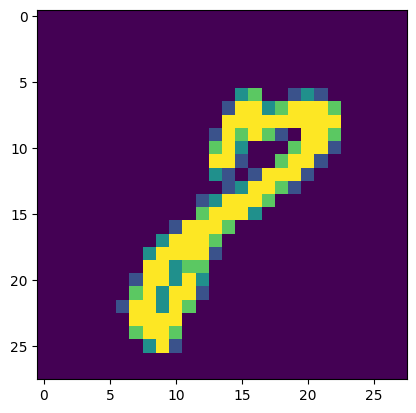

In [6]:
plt.imshow(x)

In [7]:
y

np.int64(8)

# Data loaders with pytorch

In [8]:
train_dataset = MnistDataset(
    annotations_file="../data/mnist/mnist.csv", 
    images_folder="../data/mnist/", 
    train=True, 
    transform=transform_image, 
    target_transform=None,
)
test_dataset = MnistDataset(
    annotations_file="../data/mnist/mnist.csv", 
    images_folder="../data/mnist/", 
    train=False, 
    transform=transform_image, 
    target_transform=None,
)
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [9]:
x, y = next(iter(train_dataloader))

In [11]:
x.shape

torch.Size([100, 1, 28, 28])

In [16]:
# create fully connected layer pytorch
from torch import nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, stride=1, padding=1, bias=True)  # 28x28x1 -> 28x28x12
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # devides input by 2 28x28x12 -> 14x14x12
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1, bias=True)  # 14x14x12 -> 14x14x24
        self.fc1 = nn.Linear( 7 * 7 * 24, 10)  # Fully connected layer
        # self.fc2 = nn.Linear(128, 10)  # Output layer (10 classes for digits 0-9)


    def forward(self, x):
        x = self.conv1(x) # 28x28x1 -> 28x18x12 
        x = F.relu(x)  # 28 x 28 x 12
        x = self.pool(x) # 28x18x12 -> 14x14x12
        x = self.conv2(x) # 14x14x12 -> 14x14x24
        x = F.relu(x) # 14x14x25
        x = self.pool(x) # 14x14x24 -> 7x7x24
        x = x.view(-1, 7 * 7 * 24) # flatten 
        x = self.fc1(x)
        # x = F.relu(x)
        # x = self.fc2(x)
        return x
    
# Evaluate the performance of the neural network
def evaluate(net, test_dataloader):
    ground_truths = []
    predictions = []
    net = net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        eval_loss = 0
        for x, y in tqdm(test_dataloader):
            x = x.to("cuda")
            y_pred = net(x).to('cpu')
            predicted = y_pred.argmax(dim=1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            eval_loss += F.cross_entropy(y_pred, y, reduction='sum').item()
            ground_truths.extend(y.tolist())
            predictions.extend(predicted.tolist())
        accuracy = correct / total
        eval_loss = eval_loss / total
        print(f'Eval Loss: {eval_loss}')
        print(f'Accuracy: {accuracy:.2f}')
        
    net = net.train()
    return ground_truths, predictions, accuracy, eval_loss

    

In [ ]:
very_simple_net = SimpleCNN().to('cuda')
# train very_simple_net

learning_rate = 0.001
optimizer = torch.optim.Adam(very_simple_net.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

summary_writer = SummaryWriter(log_dir='./runs/cnn_mnist')

num_epochs = 5
for epoch in range(num_epochs):
    accumulated_loss = 0
    for x, y in tqdm(train_dataloader):
        x = x.to('cuda')
        y = y.to('cuda')
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = very_simple_net(x)

        # Compute and print loss
        loss = loss_fn(y_pred, y)
        accumulated_loss += loss.item()

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'------- Epoch {epoch + 1}: Train Loss {accumulated_loss/len(train_dataloader)}')
    _, _, eval_acc, eval_loss = evaluate(very_simple_net, test_dataloader)
    summary_writer.add_scalars('Loss', {'train': accumulated_loss/len(train_dataloader), 'eval': eval_loss}, epoch)
    summary_writer.add_scalars('Accuracy', {'eval': eval_acc}, epoch)

summary_writer.close()

  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [00:08<00:00, 74.37it/s]


------- Epoch 1: Train Loss 0.38964759003371


100%|██████████| 100/100 [00:02<00:00, 36.81it/s]


Eval Loss: 0.13260524563789367
Accuracy: 0.96


100%|██████████| 600/600 [00:08<00:00, 72.99it/s]


------- Epoch 2: Train Loss 0.10590000302841265


100%|██████████| 100/100 [00:02<00:00, 39.16it/s]


Eval Loss: 0.07146368262767792
Accuracy: 0.98


100%|██████████| 600/600 [00:08<00:00, 72.98it/s]


------- Epoch 3: Train Loss 0.07185492836249371


100%|██████████| 100/100 [00:02<00:00, 46.48it/s]


Eval Loss: 0.06136503654122353
Accuracy: 0.98


100%|██████████| 600/600 [00:08<00:00, 73.55it/s]


------- Epoch 4: Train Loss 0.05846249550115317


 31%|███       | 31/100 [00:00<00:01, 37.51it/s]

100%|██████████| 157/157 [00:01<00:00, 90.87it/s] 


Eval Loss: 0.03365423967279494
Accuracy: 0.99


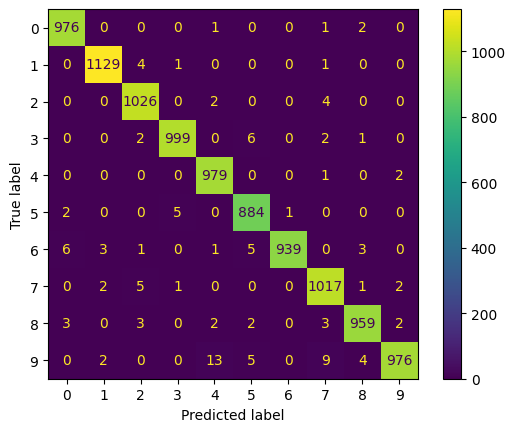

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
ground_truths, predictions, acc, eval_losses = evaluate(very_simple_net, test_dataloader)
ConfusionMatrixDisplay.from_predictions(ground_truths, predictions)
plt.show()
print(classification_report(ground_truths, predictions))